#Imports

In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem.porter import *
from collections import Counter
from collections import defaultdict
from math import log
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
%%shell
jupyter nbconvert --to html /content/Birch.ipynb

[NbConvertApp] Converting notebook /content/Birch.ipynb to html
[NbConvertApp] Writing 778079 bytes to /content/Birch.html


#Preprocessing

First we use pandas to read the TSV files into a DataFrames (double annotated training data, tripel annotated training data and the test data) 


In [ ]:
# DOUBLE ANNOTATED 
df_double = pd.read_csv('PA3_train.tsv', sep='\t')
# Renaming columns with apropriate names 
df_double = df_double.rename(columns={df_double.columns[1]: 'Review'})
df_double = df_double.rename(columns={df_double.columns[0]: 'Sentiment'})

# TRIPEL ANNOTATED
df_tripel = pd.read_csv('PA3_train_final.tsv', sep='\t')
# Renaming columns with apropriate names 
df_tripel = df_tripel.rename(columns={df_tripel.columns[1]: 'Review'})
df_tripel = df_tripel.rename(columns={df_tripel.columns[0]: 'Sentiment'})

# TEST 
df_test = pd.read_csv('PA3_test.tsv', sep='\t')
# Renaming columns with apropriate names
df_test = df_test.rename(columns={df_test.columns[1]: 'Review'})
test = df_test.rename(columns={df_test.columns[0]: 'Sentiment'})

In [ ]:
# Get a look at the double annotated data
df_double.head()

,Sentiment,Review
0,1/1,We stopped her whilst walking in the Haga area...
1,0/0,"Bad experience, On 23/03/19 Myself and my part..."
2,0/0,Extremely underwhelming experience here last n...
3,0/0,Waited 30 minutes to get a table…that was ok. ...
4,0/0,"A mediocre burger, not tasteful"


**Double annotated**: We only keep the reviews where the annotations agree. We then change the sentiment for each review so that 1/1 -> 1 and 0/0 -> 0. 

In [ ]:
# Keep only rows where 'Sentiment' is either '1/1' or '0/0'
sentiment_values = ['1/1', '0/0']
df_double_filtered = df_double[df_double['Sentiment'].isin(sentiment_values)]

# Replace values in 'Sentiment' column
sentiment_mapping = {'1/1': 1, '0/0': 0}
df_double_filtered['Sentiment'] = df_double_filtered['Sentiment'].replace(sentiment_mapping)

# Get a look at the data
df_double_filtered.head()

,Sentiment,Review
0,1,We stopped her whilst walking in the Haga area...
1,0,"Bad experience, On 23/03/19 Myself and my part..."
2,0,Extremely underwhelming experience here last n...
3,0,Waited 30 minutes to get a table…that was ok. ...
4,0,"A mediocre burger, not tasteful"


**Tripel annotated**: We set the label to the majority of the annotations. For example, 1/1/0 -> 1 and 0/-1/0 -> 0. This leads to some labels becoming -1 (inconclusive) and to ensure good labeling we drop these reviews. 

In [ ]:
# Split the sentiment column into separate columns
df_tripel[['anno1', 'anno2', 'anno3']] = df_tripel['Sentiment'].str.split('/', expand=True)

# Convert the annotation columns to integers, handling invalid values
df_tripel['anno1'] = pd.to_numeric(df_tripel['anno1'], errors='coerce').astype(float)
df_tripel['anno2'] = pd.to_numeric(df_tripel['anno2'], errors='coerce').astype(float)
df_tripel['anno3'] = pd.to_numeric(df_tripel['anno3'], errors='coerce').astype(float)

# Calculate the majority annotation for each row
df_tripel['Sentiment_majority'] = df_tripel[['anno1', 'anno2', 'anno3']].mode(axis=1).iloc[:, 0]

# Drop the individual annotation columns and the original sentiment column
df_tripel = df_tripel.drop(['anno1', 'anno2', 'anno3', 'Sentiment'], axis=1)

# Drop reviews with label -1
df_tripel_filtered = df_tripel[df_tripel['Sentiment_majority'] != -1]



We want to ensure that this filtering only causes a small amount of data loss. So in the next cells we calculate the fraction of lost data for both the double and tripel annotated data. 

In [ ]:
# DOUBLE
initial_size = df_double.shape[0]
new_size = df_double_filtered.shape[0]
data_loss = initial_size - new_size 
data_loss_frac = data_loss / initial_size
print("Nr of rows removed: " , data_loss)
print("Fraction of rows removed: " , data_loss_frac) #We consider it ok to loose barely 6% of the data 

Nr of rows removed:  396
Fraction of rows removed:  0.05643437366395896


In [ ]:
# TRIPEL
initial_size = df_tripel.shape[0]
new_size = df_tripel_filtered.shape[0]
data_loss = initial_size - new_size 
data_loss_frac = data_loss / initial_size
print("Nr of rows removed: " , data_loss)
print("Fraction of rows removed: " , data_loss_frac) #We now only have to remove just over 1% of the data instead of 6% when using double annotated data


Nr of rows removed:  100
Fraction of rows removed:  0.012992074834351046


Check that there are roughly the same number of positive reviews as negative reviews. If this is not the case we risk training a biased model. 

In [ ]:
# DOUBLE
unique_values = df_double_filtered['Sentiment'].value_counts()
print("Fraction of positive reviews: ", unique_values[0]/(unique_values[0]+unique_values[1]))
print("Fraction of negative reviews: ", unique_values[1]/(unique_values[0]+unique_values[1]))

#Roughly 50/50 positive and negative reviews - GOOD! 


Fraction of positive reviews:  0.47198308412626494
Fraction of negative reviews:  0.5280169158737351


In [ ]:
# TRIPEL
unique_values = df_tripel_filtered['Sentiment_majority'].value_counts()
print("Fraction of positive reviews: ", unique_values[0]/(unique_values[0]+unique_values[1]))
print("Fraction of negative reviews: ", unique_values[1]/(unique_values[0]+unique_values[1]))

#Roughly 50/50 positive and negative reviews - GOOD! 


Fraction of positive reviews:  0.4775569303672502
Fraction of negative reviews:  0.5224430696327498


Now we want to preproces the text in the reviews to remove noise and stadardize it. This will later help the model to only focus on the important features when classifying the reviews. First we make a function for this purpose and then we apply it to all the datasets. 

In [ ]:
# Define a function to stem a list of words
stemmer = PorterStemmer()
def stem_words(words):
    return [stemmer.stem(word) for word in words]

# Define a function to preprocess the text
def preprocess_text(text):
    # Remove punctuation
    text = text.replace("[^a-zA-Z#]", " ")
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if not token in stop_words]

    # Stem each word in the list
    stemmed_words = [stemmer.stem(word) for word in tokens]

    # Join the tokens back into a string
    text = ' '.join(stemmed_words)
    return text

In [ ]:
# Apply preprocessing to all datasets 
df_double_filtered['Review'] = df_double_filtered['Review'].apply(preprocess_text)
df_tripel_filtered['Review'] = df_tripel_filtered['Review'].apply(preprocess_text)
df_test['Review'] = df_test['Review'].apply(preprocess_text)

<ipython-input-153-cd426a8a231d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_double_filtered['Review'] = df_double_filtered['Review'].apply(preprocess_text)
<ipython-input-153-cd426a8a231d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tripel_filtered['Review'] = df_tripel_filtered['Review'].apply(preprocess_text)


# Developing a multinomial naive bayes model

In [ ]:
class Multi_NB(): 

  def __init__(self, alpha): #Alpha is the smoothing parameter that handles words with zero counts
    self.alpha = alpha 
    self.priors = []
    self.theta_neg = []
    self.theta_pos = []

  # Creates a list of all unique words that appeare in the given list 
  def create_vocabulary(self, listy):
    words = listy.str.split().tolist()
    vocabulary = set([word for sublist in words for word in sublist])
    return vocabulary
  
  # Calculates the prior proability of a review have either positive or negative sentiment
  # The prior probability for positive sentiment is simply the number of positive review divided by total number of review and vice versa fro negative sentiment 
  def caluculate_prior(self, y_train): 
    neg, pos = y_train.value_counts() #number of negative review, number of positive review
    total_rev = len(y_train)
    prior = [neg/total_rev, pos/total_rev]
    return prior

  # Creates two lists with the positive and negative reviews 
  def get_pos_and_neg(self,X_train, Y_train):
    pos_rev = []
    neg_rev = []
    for i in range(len(Y_train)):
      if Y_train.iloc[i]==0:
        neg_rev.append(X_train.iloc[i])
      else:
        pos_rev.append(X_train.iloc[i])
    return  neg_rev, pos_rev
  
  # Returns how many words are in a list 
  def get_num_words(self,list): 
    # Join all strings into one long string
    all_strings = ' '.join(list)

    # Split the long string into words
    all_words = all_strings.split()

    # Count the number of words
    return len(all_words)
  
  # Calculates the conditinal proability for each word in the vocabulary given a set of sentences (negative or positive reviews)
  def calculate_cond_prob(self, vocabulary, sentences): 
    total_nr_words = self.get_num_words(sentences)
    
    # Create a defaultdict to store the frequency of each word in the vocabulary
    word_count = defaultdict(int)

    # Iterate through each string in the list of strings
    for sentence in sentences:
        # Split the string into individual words
        words = sentence.split()
        # Iterate through each word in the list of words
        for word in words:
            # If the word is in the vocabulary, increment its count in the defaultdict
            if word in vocabulary:
                word_count[word] += 1

    # Create a dictionary that maps each word in the vocabulary to its count
    counts = {word: (word_count[word]+self.alpha)/(total_nr_words +self.alpha*len(vocabulary)) for word in vocabulary}

    return counts

  # Fits the model by assigning values to the attributes (priors, theta_neg and theta_pos)
  def fit(self, X_train, Y_train):
    
    # Create vocabulary from the given texts
    vocabulary = self.create_vocabulary(X_train)

    # Calculate he priors P(y)
    self.priors = self.caluculate_prior(Y_train)

    # Dividing reviews into pos and neg
    neg_rev, pos_rev = self.get_pos_and_neg(X_train, Y_train)
    
    # Calculate conditional probabilities P(x_i|y) for both labels 
    self.theta_neg = self.calculate_cond_prob(vocabulary, neg_rev)
    self.theta_pos = self.calculate_cond_prob(vocabulary, pos_rev)
  
  # Given a list of reviews it predicts the sentiemnt to either positive (1) or negative (0)
  def predict(self, X_test): 
    y_pred = []
    for rev in X_test:
        # Calculate log probabilities for each label
        neg_prob = log(self.priors[0])
        pos_prob = log(self.priors[1])
        for word in rev.split():
            if word in self.theta_neg:
                neg_prob += log(self.theta_neg[word])
            if word in self.theta_pos:
                pos_prob += log(self.theta_pos[word])
        # Choose the label with the highest probability
        if pos_prob > neg_prob:
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred
 
  # Measures the performance by calculating accuracy, precision, recall and f1 
  def score(self, X_test, Y_test):
      # Get predicted labels using predict method
      y_pred = self.predict(X_test)

      # Calculate evaluation metrics
      accuracy = accuracy_score(Y_test, y_pred)
      precision = precision_score(Y_test, y_pred, average='macro')
      recall = recall_score(Y_test, y_pred, average='macro')
      f1 = f1_score(Y_test, y_pred, average='macro')

      return accuracy, precision, recall, f1


# Dividing the datasets into X and y


This means to split each dataset into one list with the reviews (X-values) and a corresponding list with the sentiments (y-values) 

In [ ]:
df_tripel_filtered.head()

,Review,Sentiment_majority
0,stop whilst walk haga area . cafe well recomme...,1.0
1,"bad experi , 23/03/19 partner arriv 20.00 prom...",0.0
2,extrem underwhelm experi last night . group fr...,0.0
3,wait 30 minut get table‚ä¶that ok. sat tabl wa...,0.0
4,"mediocr burger , tast",0.0


In [ ]:
# DOUBLE
X_train_double = df_double_filtered.iloc[:,1]
y_train_double = df_double_filtered.iloc[:,0]

# TRIPLE
X_train_tripel = df_tripel_filtered.iloc[:,0]
y_train_tripel = df_tripel_filtered.iloc[:,1].astype(int)

# TESTS
X_test = df_test.iloc[:,1]
y_test = df_test.iloc[:,0]

#Tweeking the hyper parameter alpha (smoothing parameter) 

We want to use the best possible value for alpha so we test the accuracy of the model with different values of alpha and choose the alpha that yields the highest accuracy. We use the double annotated dataset for this validation and use it when training the model using both the double annotated data and the tripel annotated data. We consider this sufficent since the two datasets are very similar. 

In [ ]:
alphas = np.linspace(0.1,20.1,21) #List of different alpha values
accuracys = [] #List of corresponding accuracys

# Append to accuracys list 
for alpha in alphas: 
  M = Multi_NB(alpha = alpha)
  M.fit(X_train_double, y_train_double)
  predictions = M.predict(X_test)
  accuracy, precision, recall, f1 = M.score(X_test, y_test)
  accuracys.append(accuracy)

Text(0.5, 1.0, 'Accuracy vs Smoothing Parameter')

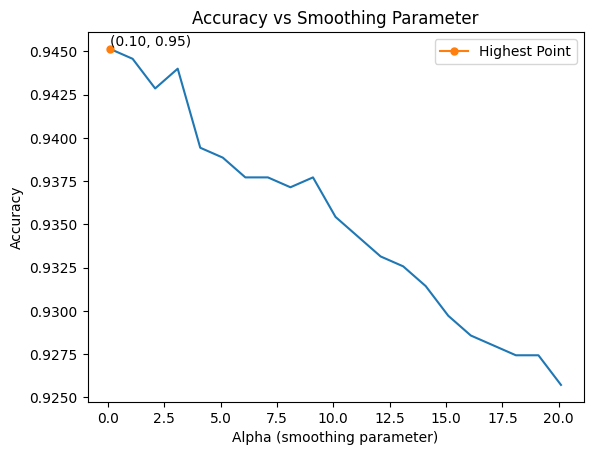

In [ ]:
# Plot accuracy vs alpha 
plt.plot(alphas, accuracys)
plt.xlabel("Alpha (smoothing parameter)")
plt.ylabel("Accuracy")

# Find index of highest point
highest_point_index = np.argmax(accuracys)

# Extract x and y coordinates of the highest point
highest_x = alphas[highest_point_index]
highest_y = accuracys[highest_point_index]

plt.plot(highest_x, highest_y, marker='o', markersize=5, label='Highest Point')
# Print out the coordinates of the highest point
plt.text(highest_x, highest_y, f'({highest_x:.2f}, {highest_y:.2f})', ha='left', va='bottom')
plt.legend()
plt.title("Accuracy vs Smoothing Parameter")


# Fitting and testing the model

In [ ]:
# DOUBLE
M = Multi_NB(alpha = 0.1)
M.fit(X_train_double, y_train_double)
predictions = M.predict(X_test)
accuracy, precision, recall, f1 = M.score(X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Accuracy:  0.9451428571428572
Precision:  0.9451506222375474
Recall:  0.9452204038123903
F1:  0.945141065830721


In [ ]:
# TRIPEL
M = Multi_NB(alpha = 0.1)
M.fit(X_train_tripel, y_train_tripel)
predictions = M.predict(X_test)
accuracy, precision, recall, f1 = M.score(X_test, y_test)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Accuracy:  0.94
Precision:  0.94
Recall:  0.9400695489507567
F1:  0.939997629294088


# Comparison against other classifiers

(This is only done with the double annotated data) 

**Dummy classifier**

We compare our performance with a dummy classifier that just classifies the reviews based on frequency. This appraoch gives 50% accuracy which is expected since there is 50/50 positive and negative reviews. 

We know that the classifier we devloped is doing something smart since it is much better than the dummy classifier. 

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_double, y_train_double)

dummy_clf.score(X_test, y_test) #50% which is expected since half of the reviews are positive and the other half is negative

0.5062857142857143

**Built in multinomial classifier**

To further evaluate our model we compare it to the sk learn multinomial classifier. Since we get about the same accuracy as for our own model this also indicates the our model actually is doing somtehing smart. 

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train_double)
clf = MultinomialNB()
clf.fit(X, y_train_double)
X_tes = vectorizer.transform(X_test)
y_pred = clf.predict(X_tes)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9428571428571428


# Confusion matrix

The confusion matrix shows when the model makes the right and wrong predictions. We can see that it makes about the same wrong predictions for both positive and negative reviews. 

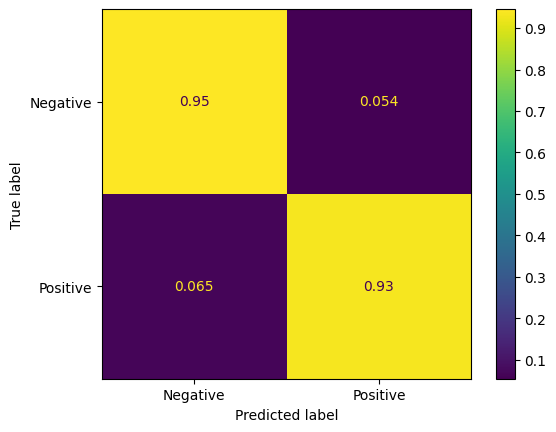

In [ ]:
from sklearn import metrics

M = Multi_NB(alpha = 0.1)
M.fit(X_train_tripel, y_train_tripel)
predictions = M.predict(X_test)

# NORMALIZED

confusion_matrix = metrics.confusion_matrix(y_test.to_numpy(), predictions)
normalized_confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=normalized_confusion_matrix, display_labels=["Negative", "Positive"])
cm_display.plot()

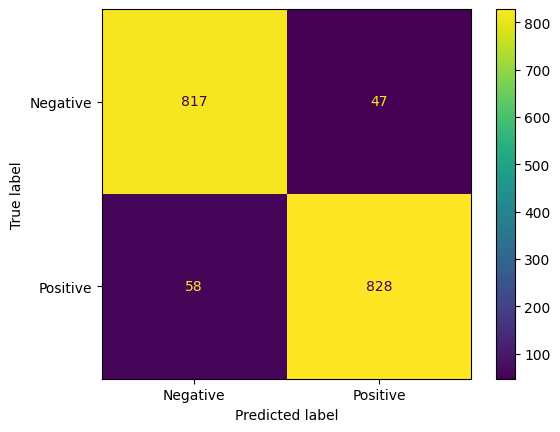

In [ ]:
# COUNTS

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Negative", "Positive"])
cm_display.plot()